#### Section 2.6: Single Assay Pair Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn import metrics 
from matplotlib.ticker import PercentFormatter


In [4]:
raw_dat_dir = '/home/grace/Documents/python/genetox/data/raw/'
processed_dat_dir = '/home/grace/Documents/python/genetox/data/processed/'
interim_dat_dir = '/home/grace/Documents/python/genetox/data/interim/'
figures_dir = '/home/grace/Documents/python/genetox/reports/figures/'

In [5]:
genetox = pd.read_excel(processed_dat_dir+'genetox_merged_110221_final.xlsx')

In [6]:
df_demarini = pd.read_csv(processed_dat_dir+'DeMarini_calls_120221.csv')

In [7]:
df_demarini.head()

,dtxsid,DeMarini_call,DeMarini_outcome
0,DTXSID00100498,not clastogen,0.0
1,DTXSID00100670,non gentox,0.0
2,DTXSID00100756,non gentox,0.0
3,DTXSID00101041,gentox,1.0
4,DTXSID00101061,clastogen,1.0


In [36]:
df_demarini.DeMarini_outcome.value_counts(dropna = False)
#df_demarini.shape

0.0    5585
1.0    2728
NaN     129
Name: DeMarini_outcome, dtype: int64


#### Resampling: Sample 1 ames and 1 clastogen activity for each chemical from the experimental data (underlying distribution).

- For each sample derive the Genetox classification as per the categorisation scheme
- Calculate the overall variance/accuracy of agreement as a measure of reproducibility
- Calculate the unalikability index as a measure of overall agreeability of experimental values/chemical



In [8]:
n_bootstraps = 500
AmesSubsetforBootstrap = pd.DataFrame(index=[], \
                                      columns=['dtxsid','AmesOutcomeArraynoInc', '%AmesPos', '%AmesNeg','AmesUnalikeability',\
                                               'AmesBootstrappedArray', '%bAmesPos', '%bAmesNeg','AmesBUnalikeability',\
                                               'ClasOutcomeArraynoInc', '%ClasPos', '%ClasNeg','ClasUnalikeability',\
                                               'ClasBootstrappedArray', '%bClasPos', '%bClasNeg','ClasBUnalikeability',\
                                               'DeMariniBootstrapped'])
idx = 0
for dtxsid, group in genetox.groupby('dtxsid'):
    #cas = group['casrn'].unique()
    AmesOutcomeArray = np.array(group[group['simple_aggregate']=='Ames']['assay_outcome'])
    ClasOutcomeArray = np.array(group[group['simple_aggregate']=='clastogen']['assay_outcome'])
    # Remove all the inconclusive outcomes
    AmesOutcomeArraynoInc = AmesOutcomeArray[~np.isin(AmesOutcomeArray,(2))]
    ClasOutcomeArraynoInc = ClasOutcomeArray[~np.isin(ClasOutcomeArray,(2))]
    if len(AmesOutcomeArraynoInc) > 2:
        # create a bootstraped value array
        AmesBootstrapvalues = np.array(np.random.choice(AmesOutcomeArraynoInc, replace=True, size=n_bootstraps))
        try:
            ClasBootstrapvalues = np.array(np.random.choice(ClasOutcomeArraynoInc, replace=True, size=n_bootstraps))
        except:
            ClasBootstrapvalues = np.array([])
        # Calculate the % of 0,1 and 2 (non-mutagenic, mutagenic and inconclusives) in original data
        AmesPercPos = 100*(AmesOutcomeArraynoInc==1).sum()/len(AmesOutcomeArraynoInc)
        AmesPercNeg = 100*(AmesOutcomeArraynoInc==0).sum()/len(AmesOutcomeArraynoInc)
        Amesunalikeability = 2*AmesPercPos*AmesPercNeg/10000 #keep it as a number between 0 and 1
        #PercInc = 100*(AmesOutcomeArraynoInc==2).sum()/len(AmesOutcomeArraynoInc)
        # Calculate the % of 0,1 and 2 (clastogenicity) in original data
        ClasPercPos = 100*(ClasOutcomeArraynoInc==1).sum()/len(ClasOutcomeArraynoInc)
        ClasPercNeg = 100*(ClasOutcomeArraynoInc==0).sum()/len(ClasOutcomeArraynoInc)
        Clasunalikeability = 2*ClasPercPos*ClasPercNeg/10000 #keep it as a number between 0 and 1
        
        # Calculate the % of 0,1 and 2 (non-mutagenic, mutagenic and inconclusives) in bootsstrapped data
        AmesBPercPos = 100*(AmesBootstrapvalues==1).sum()/n_bootstraps
        AmesBPercNeg = 100*(AmesBootstrapvalues==0).sum()/n_bootstraps
        AmesBunalikeability = 2*AmesBPercPos*AmesBPercNeg/10000 #keep it as a number between 0 and 1
        #bPercInc = 100*(bootstrapvalues==2).sum()/n_bootstraps
        # Calculate the % of 0,1 and 2 (clastogenicity) in bootsstrapped data
        ClasBPercPos = 100*(ClasBootstrapvalues==1).sum()/n_bootstraps
        ClasBPercNeg = 100*(ClasBootstrapvalues==0).sum()/n_bootstraps
        ClasBunalikeability = 2*ClasBPercPos*ClasBPercNeg/10000 #keep it as a number between 0 and 1
               
        # Derive DeMarini Call for each bootstrap
        bootstrapdemarini = []
        for i, ames in enumerate(AmesBootstrapvalues):
            if ames == 1:
                bootstrapdemarini.append(1)
            else:
                try:
                    clas = ClasBootstrapvalues[i]
                    if clas == 1:
                        bootstrapdemarini.append(1)
                    else:
                        bootstrapdemarini.append(0)   
                except:
                    bootstrapdemarini.append(0)
            
        # Update the DataFrame
        AmesSubsetforBootstrap.loc[idx,'dtxsid'] = dtxsid
        #Ames
        AmesSubsetforBootstrap.loc[idx, 'AmesOutcomeArraynoInc'] = AmesOutcomeArraynoInc
        AmesSubsetforBootstrap.loc[idx, '%AmesPos']= AmesPercPos
        AmesSubsetforBootstrap.loc[idx, '%AmesNeg'] = AmesPercNeg
        AmesSubsetforBootstrap.loc[idx, 'AmesUnalikeability'] = Amesunalikeability
        AmesSubsetforBootstrap.loc[idx, 'AmesBootstrappedArray'] = AmesBootstrapvalues
        AmesSubsetforBootstrap.loc[idx, '%bAmesPos']= AmesBPercPos
        AmesSubsetforBootstrap.loc[idx, '%bAmesNeg'] = AmesBPercNeg    
        AmesSubsetforBootstrap.loc[idx, 'AmesBUnalikeability'] = float(AmesBunalikeability)
        # Clas
        AmesSubsetforBootstrap.loc[idx, 'ClasOutcomeArraynoInc'] = ClasOutcomeArraynoInc
        AmesSubsetforBootstrap.loc[idx, '%ClasPos']= ClasPercPos
        AmesSubsetforBootstrap.loc[idx, '%ClasNeg'] = ClasPercNeg
        AmesSubsetforBootstrap.loc[idx, 'ClasUnalikeability'] = Clasunalikeability
        AmesSubsetforBootstrap.loc[idx, 'ClasBootstrappedArray'] = ClasBootstrapvalues
        AmesSubsetforBootstrap.loc[idx, '%bClasPos']= ClasBPercPos
        AmesSubsetforBootstrap.loc[idx, '%bClasNeg'] = ClasBPercNeg    
        AmesSubsetforBootstrap.loc[idx, 'ClasBUnalikeability'] = float(ClasBunalikeability)
        # DeMarini calls
        AmesSubsetforBootstrap.loc[idx, 'DeMariniBootstrapped'] = bootstrapdemarini
        # Update the index
        idx=idx+1

AmesSubsetforBootstrap.index = AmesSubsetforBootstrap['dtxsid']
AmesSubsetforBootstrap.to_csv(processed_dat_dir+'AmesBootstrapAnalysis_120221.csv', index_label = 'dtxsid')

/home/grace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars
/home/grace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


In [9]:
AmesSubsetforBootstrap.head()

,dtxsid,AmesOutcomeArraynoInc,%AmesPos,%AmesNeg,AmesUnalikeability,AmesBootstrappedArray,%bAmesPos,%bAmesNeg,AmesBUnalikeability,ClasOutcomeArraynoInc,%ClasPos,%ClasNeg,ClasUnalikeability,ClasBootstrappedArray,%bClasPos,%bClasNeg,ClasBUnalikeability,DeMariniBootstrapped
dtxsid,,,,,,,,,,,,,,,,,,
DTXSID00100670,DTXSID00100670,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,100,0,"[0, 0, 0, 0]",0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
DTXSID00104436,DTXSID00104436,"[0, 0, 0]",0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,100,0,[0],0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
DTXSID00108550,DTXSID00108550,"[0, 0, 0]",0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,100,0,"[0, 0]",0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
DTXSID00109022,DTXSID00109022,"[0, 0, 0]",0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,100,0,"[0, 0]",0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
DTXSID00109168,DTXSID00109168,"[0, 0, 0, 0, 0, 0]",0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,100,0,"[0, 0]",0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
AmesSubsetforBootstrap.shape

(3233, 18)

In [13]:
df_demarini = df_demarini.set_index('dtxsid')


#### Calculate equivalence|accuracy of bootstrap DeMarini against original DeMarini calls

In [14]:
evaluationdataset = pd.concat([AmesSubsetforBootstrap['DeMariniBootstrapped'], df_demarini], axis = 1).dropna()

In [15]:
evaluationdataset

,DeMariniBootstrapped,DeMarini_call,DeMarini_outcome
DTXSID00100670,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,0.0
DTXSID00104436,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,0.0
DTXSID00108550,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,0.0
DTXSID00109022,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,0.0
DTXSID00109168,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,0.0
...,...,...,...
DTXSID9094828,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,0.0
DTXSID9097381,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,0.0
DTXSID9098147,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,0.0
DTXSID9099080,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,0.0


In [16]:
#AmesSubsetforBootstrap['DeMarini'] = df_demarini
bootstrapacc = []
for idx in evaluationdataset.index:
    x = np.empty(n_bootstraps)
    x.fill(evaluationdataset.loc[idx, 'DeMarini_outcome'])
    y = evaluationdataset.loc[idx, 'DeMariniBootstrapped']
    acc = 100*np.round(metrics.accuracy_score(x, y),2)
    evaluationdataset.loc[idx, 'DeMariniBootstrappedAccuracy'] = acc


In [17]:
evaluationdataset.head()

,DeMariniBootstrapped,DeMarini_call,DeMarini_outcome,DeMariniBootstrappedAccuracy
DTXSID00100670,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,0.0,100.0
DTXSID00104436,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,0.0,100.0
DTXSID00108550,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,0.0,100.0
DTXSID00109022,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,0.0,100.0
DTXSID00109168,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",non gentox,0.0,100.0


#### Plot Unalikeability

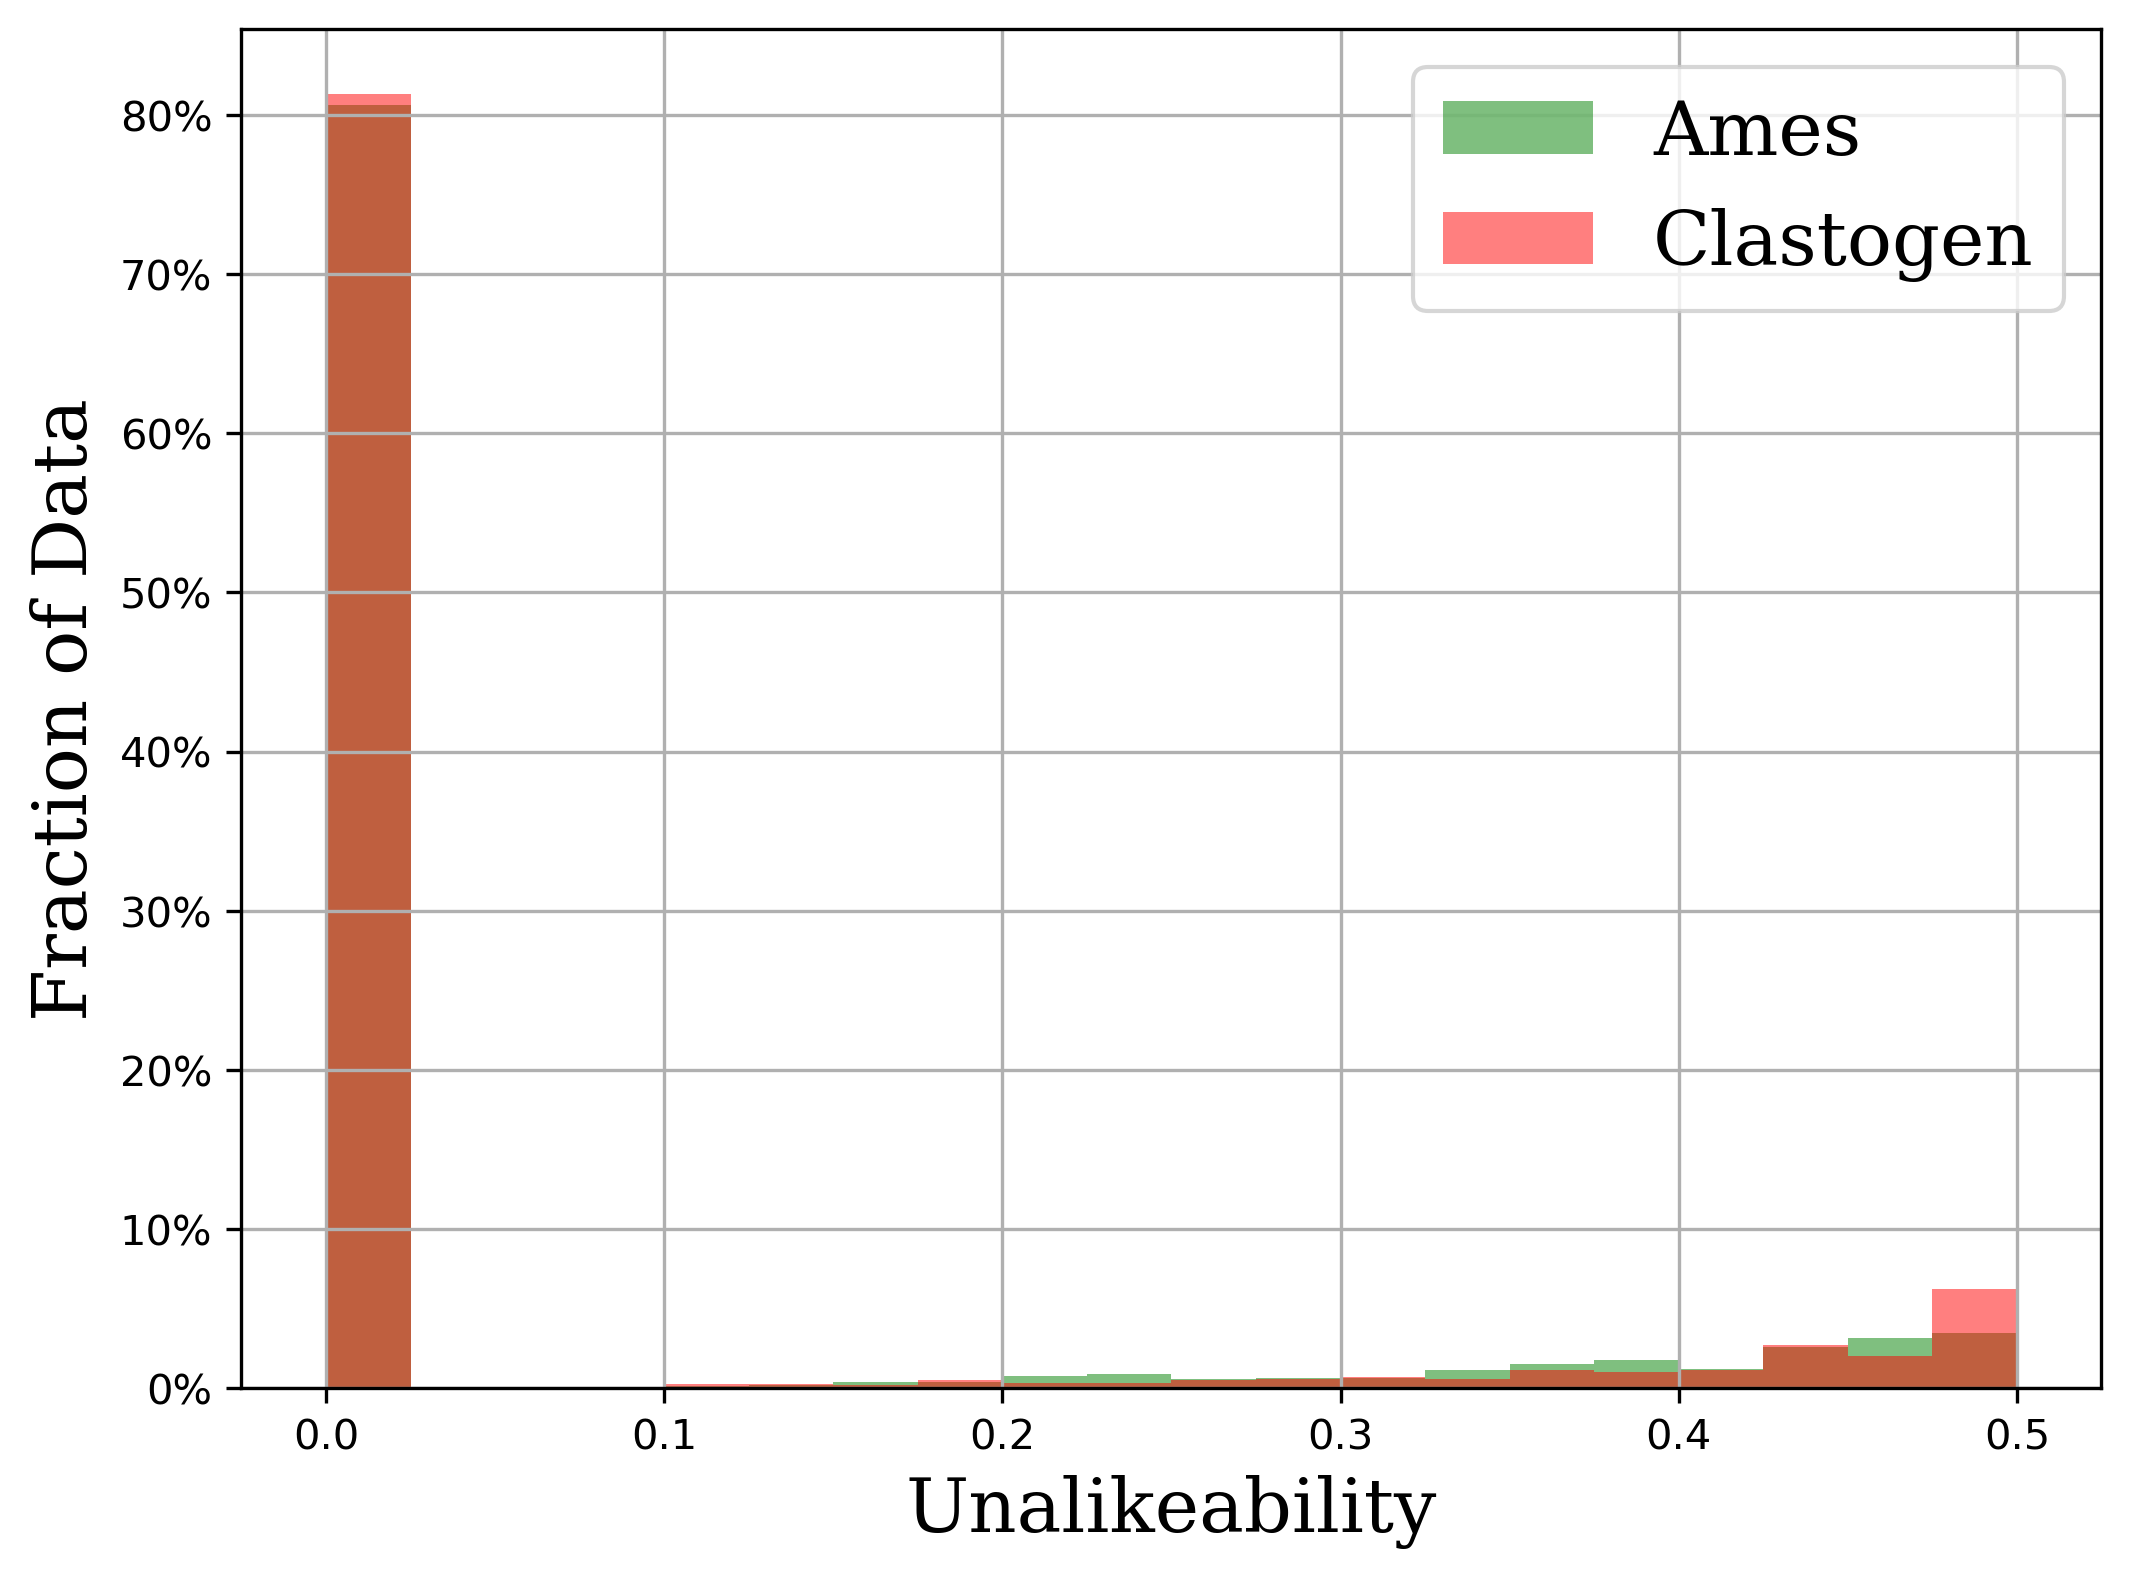

In [19]:
plt.figure(figsize=(8, 6), dpi = 300)
Amestotaldata = len(AmesSubsetforBootstrap['AmesBUnalikeability'].dropna())
AmesSubsetforBootstrap['AmesBUnalikeability'].astype('float64').hist(bins=20,  weights=np.ones(Amestotaldata)/(Amestotaldata), color='g', alpha=0.5, label='Ames')

Clastotaldata = len(AmesSubsetforBootstrap['ClasBUnalikeability'].dropna())
AmesSubsetforBootstrap['ClasBUnalikeability'].astype('float64').hist(bins=20,  weights=np.ones(Clastotaldata)/(Clastotaldata), color='r', alpha=0.5, label='Clastogen')

plt.legend(prop={'size':18,'family':'serif'})
plt.xlabel('Unalikeability', fontsize=18, family = 'serif')
plt.ylabel('Fraction of Data', fontsize=18, family = 'serif')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig(figures_dir+'unalikeability_120221.png', bbox_inches='tight')

#### Figure 7: Plot reproducibility

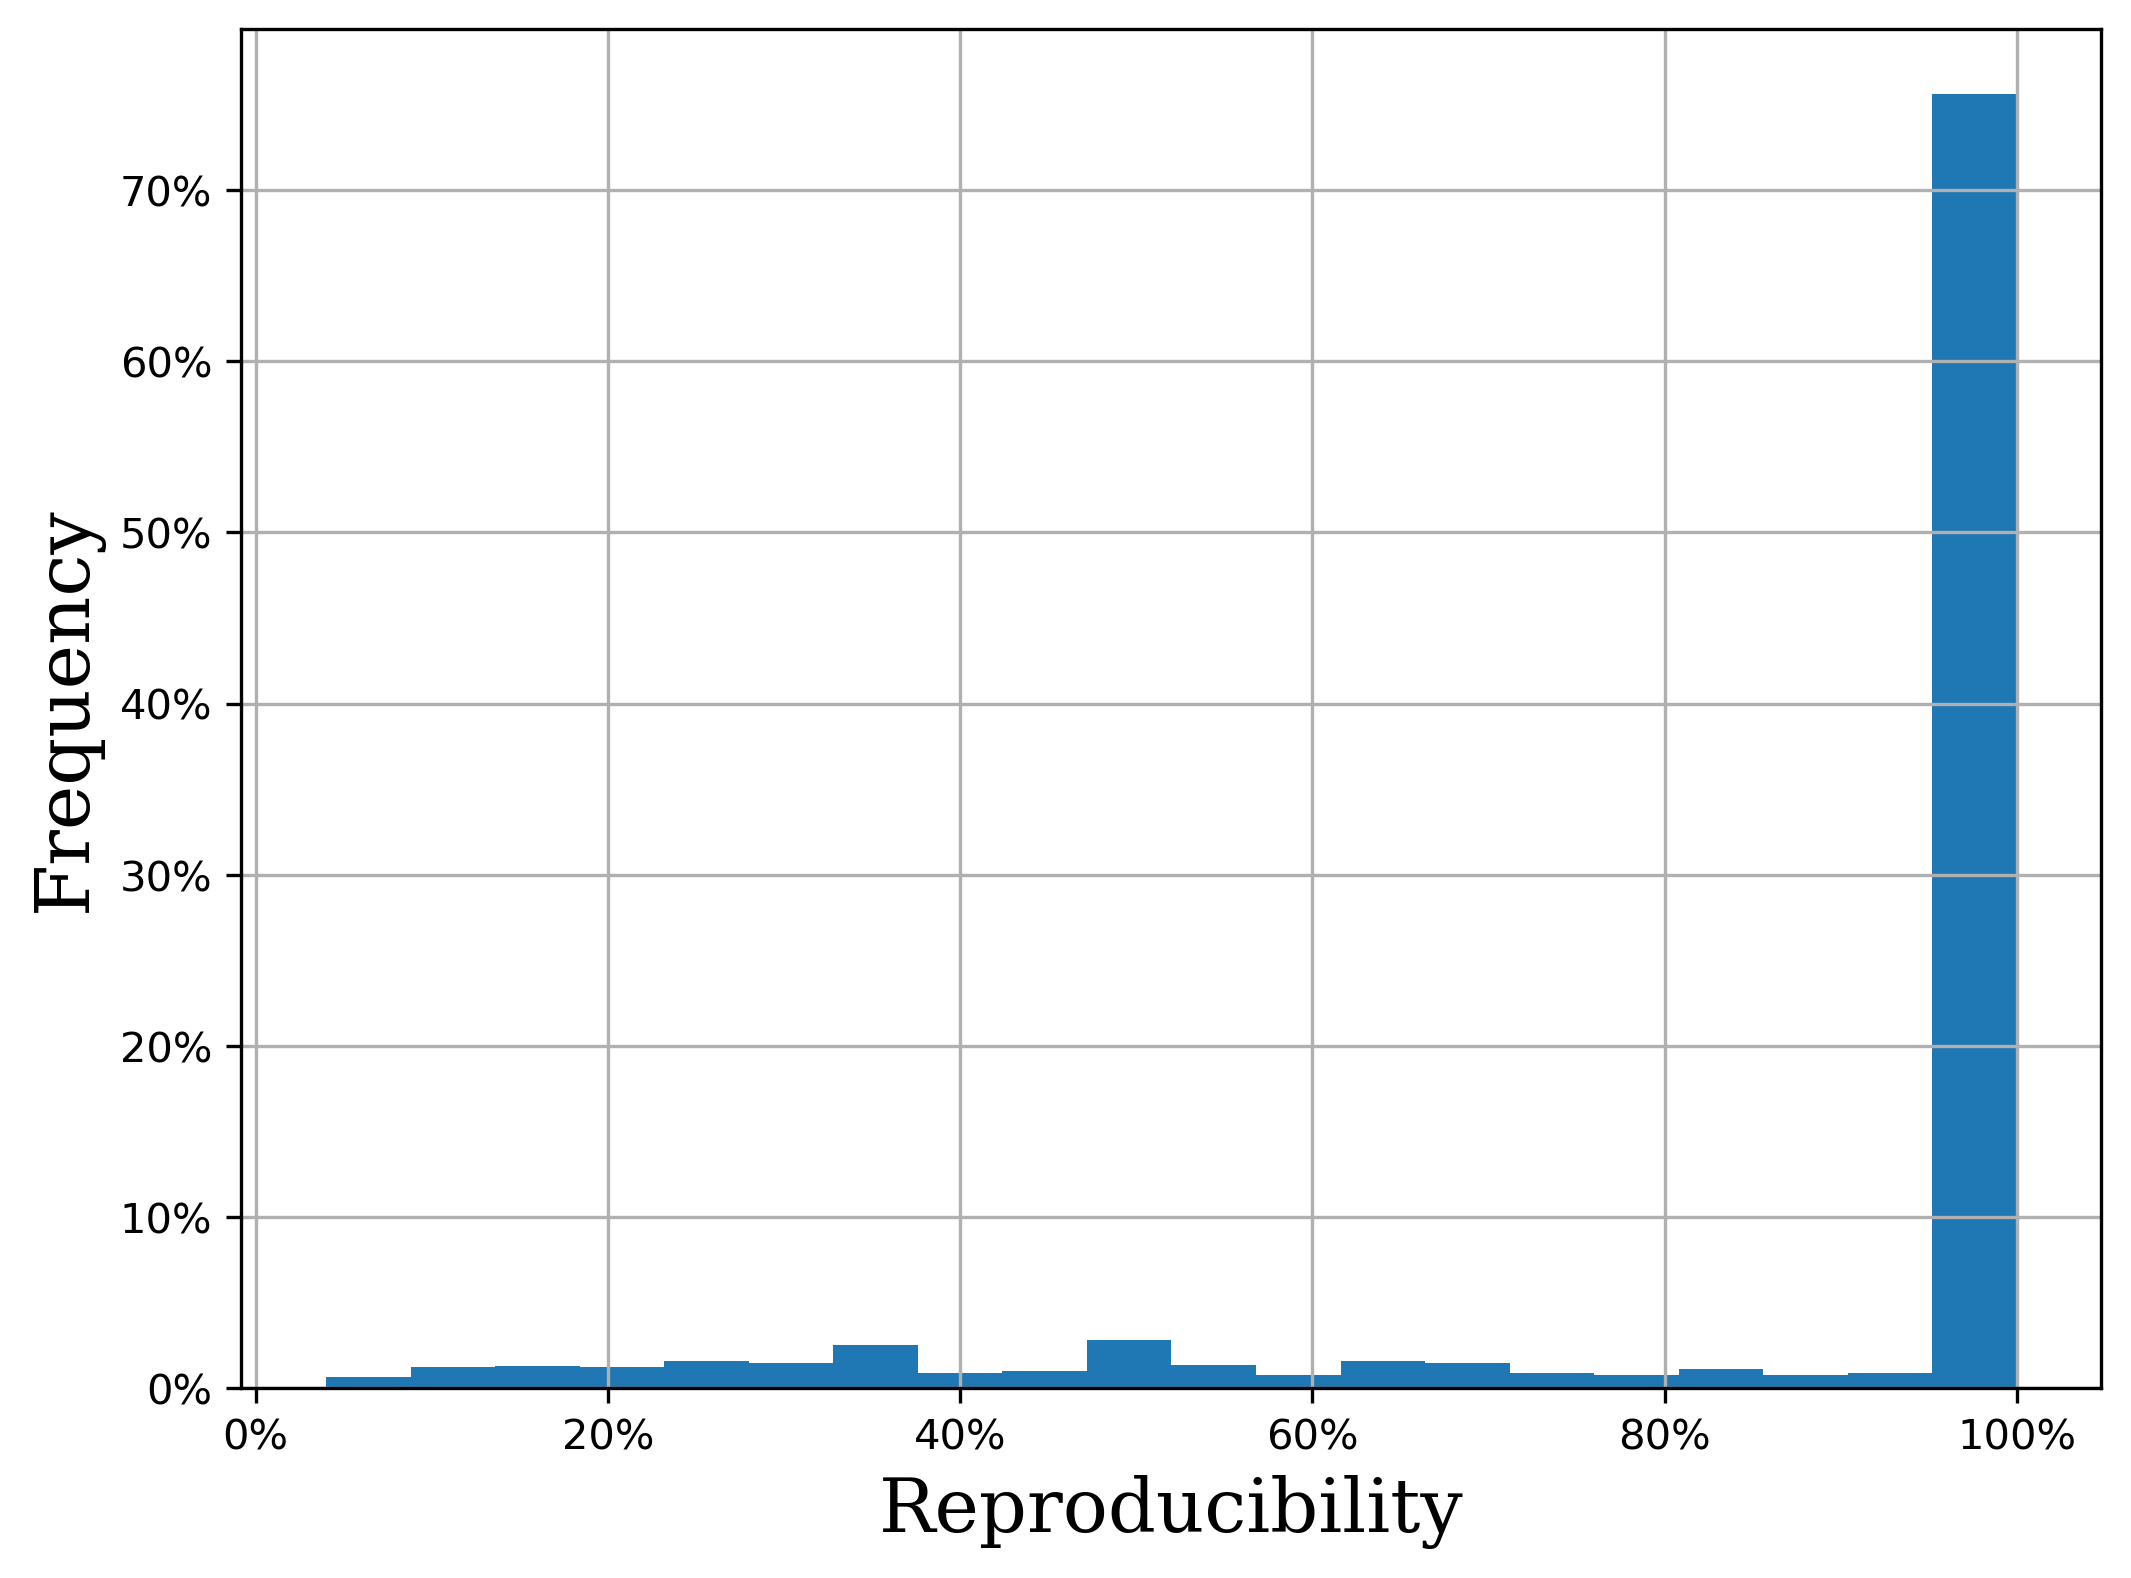

In [20]:
plt.figure(figsize=(8, 6), dpi = 300)
plt.grid(True)
totaldata = len(evaluationdataset['DeMariniBootstrappedAccuracy'])
plt.hist(evaluationdataset['DeMariniBootstrappedAccuracy'], bins=20,  weights=np.ones(totaldata)/(totaldata))
#plt.legend(prop={'size':18,'family':'serif'})
plt.xlabel('Reproducibility', fontsize=18, family = 'serif')
plt.ylabel('Frequency', fontsize=18, family = 'serif')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(100))
plt.savefig(figures_dir+'demariniReproducibility_120221.png', bbox_inches='tight')

In [22]:
evaluationdataset['DeMariniBootstrappedAccuracy'].value_counts()

100.0    2388
49.0       24
51.0       23
48.0       23
33.0       22
         ... 
55.0        3
58.0        2
99.0        2
63.0        1
4.0         1
Name: DeMariniBootstrappedAccuracy, Length: 95, dtype: int64